# Model module tutorial

This tutorial is a part of Model module guide. Here, we explore how you can use the TensorflowModel wrapper to use your Tensorflow deep learning models in the benchmark.

In [1]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import sys
sys.path.insert(0,'../../')

In [2]:
# Python packages
import gc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# Keras imports
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
# Benchmark modules
from OpenDenoising import data
from OpenDenoising import model
from OpenDenoising import evaluation

Using TensorFlow backend.


In [5]:
# Configuring the default session for Keras and Tensorflow

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [6]:
def display_results(clean_imgs, noisy_imgs, rest_images, name):
    """Display denoising results."""
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    
    plt.suptitle("Denoising results using {}".format(name))

    for i in range(5):
        axes[i, 0].imshow(np.squeeze(clean_imgs[i]), cmap="gray")
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Ground-Truth")

        axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Noised Image")

        axes[i, 2].imshow(np.squeeze(rest_imgs[i]), cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Restored Images")

In [7]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

In [8]:
# Training images generator
train_generator = data.DatasetFactory.create(path="../../tmp//BSDS500/Train",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             preprocessing=[partial(data.gen_patches, patch_size=40),
                                                            partial(data.dncnn_augmentation, aug_times=1)],
                                             name="BSDS_Train")

In [9]:
# Validation images generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             name="BSDS_Valid")

# Tensorflow Model <a class="anchor" id="tensorflow-model"></a>
---


# Navigation
---
* [Charging a model](#tf-charging-a-model)
    * [From a function](#tf-from-func)
    * [Using tf.train API](#tf-from-tfTrain)
    * [Using SavedModel API](#tf-from-savedmodel)
* [Running inference](#tf-running-inference)
* [Training a TfModel](#training-a-tfmodel)



## Charging a model <a class="anchor" id="tf-charging-a-model"></a>
---

As Keras models, we have two possibilities to build the computational graph of a Deep Learning model: by using a function, or by using a file. As the functions for creating Keras Models, the functions used to build Tensorflow model will construct the operations of your architecture.

Another peculiarity from Tensorflow models is Batch Normalization. As stated in their [documentation](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization) a Batch Normalization layer uses a parameter called "training", that switches computations between training and evaluation phases. As it turns out, [this parameter is essential for the performance of your model](https://www.alexirpan.com/2017/04/26/perils-batch-norm.html), and since most of Deep Learning architectures involve a Batch Normalization layer, we assume that every Tensorflow model has a placeholder holding a boolean to swith between training and inference.

Loading Tensorflow models from files is also simillar to loading Keras models from files. The way Tensorflow handles pre-trained models depends on which module it is used. There are two main APIs for doing this,

* The [tf.train.Saver API](https://www.tensorflow.org/api_docs/python/tf/train/Saver), which saves models as checkpoints.
* The [SavedModel API](https://www.tensorflow.org/guide/saved_model), which adds abstractions to help when reloading the network's graph.

As a remark, we encourage you to use informative names in your variables, such as "input" for graph's input, and "output" for its output.

### From a function <a class="anchor" id="tf-from-func"></a>

Tensorflow does all its work on the background, as it builds a computational graph that stays in memory whether or not it is attached to Python's variables. For instance, 

```Python
>>> a = tf.Variable(initial_value=np.ones([5, 1]), name="MyTestVariable")
tf.Variable 'MyTestVariable:0' shape=(5, 1) dtype=float64_ref
>>> a = None
>>> tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="MyTestVariable")[0]
tf.Variable 'MyTestVariable:0' shape=(5, 1) dtype=float64_ref
```

As we can see, the Tensorflow variable "MyTestVariable" continues in memory regardless its connection to Python's variable "a". Hence, the model function only needs to build the Tensorflow computational graph. Once the computational graph is constructed, we may use Tensorflow's graph utils to retrieve tensor names. For instance, consider the following function:

In [10]:
def tf_dncnn(depth=17, n_filters=64, kernel_size=3, n_channels=1, channels_first=False):
    """Tensorflow implementation of dncnn. Implementation was based on https://github.com/wbhu/DnCNN-tensorflow.

    Parameters
    ----------
    depth : int
        Number of fully convolutional layers in dncnn. In the original paper, the authors have used depth=17 for non-
        blind denoising and depth=20 for blind denoising.
    n_filters : int
        Number of filters on each convolutional layer.
    kernel_size : int tuple
        2D Tuple specifying the size of the kernel window used to compute activations.
    n_channels : int
        Number of image channels that the network processes (1 for grayscale, 3 for RGB)
    channels_first : bool
        Whether channels comes first (NCHW, True) or last (NHWC, False)
    """
    assert (n_channels == 1 or n_channels == 3), "Expected 'n_channels' to be 1 or 3, but got {}".format(n_channels)

    if channels_first:
        data_format = "channels_first"
        input_tensor = tf.placeholder(tf.float32, [None, n_channels, None, None], name="input")
    else:
        data_format = "channels_last"
        input_tensor = tf.placeholder(tf.float32, [None, None, None, n_channels], name="input")
    is_training = tf.placeholder(tf.bool, (), name="is_training")

    with tf.variable_scope('block1'):
        output = tf.layers.conv2d(inputs=input_tensor,
                                  filters=n_filters,
                                  kernel_size=kernel_size,
                                  padding='same',
                                  data_format=data_format,
                                  activation=tf.nn.relu)
    for layers in range(2, depth):
        with tf.variable_scope('block%d' % layers):
            output = tf.layers.conv2d(inputs=output,
                                      filters=n_filters,
                                      kernel_size=kernel_size,
                                      padding='same',
                                      name='conv%d' % layers,
                                      data_format=data_format,
                                      use_bias=False)
            output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
    with tf.variable_scope('block{}'.format(depth)):
        noise = tf.layers.conv2d(inputs=output,
                                 filters=n_channels,
                                 kernel_size=kernel_size,
                                 padding='same',
                                 data_format=data_format,
                                 use_bias=False)
    output = tf.subtract(input_tensor, noise, name="output")

In [11]:
tfmodel_ex1 = model.TfModel(model_name="TensorflowDnCNN", logdir="../../training_logs/Tensorflow")

In [12]:
tfmodel_ex1.charge_model(model_function=tf_dncnn)

Loading model from model function. Be sure to train your network before using it.


In [13]:
# Resets variables and tf graph
tfmodel_ex1 = None
tf.reset_default_graph()
gc.collect()

4

### From a file

Saving and restoring tensorflow models from files depend on which API was used during training, but their outputs are simillar. Bellow, we cover how we can build a TfModel using each of the APIs.

### Using tf.train API <a class="anchor" id="tf-from-tfTrain"></a>

The tf.train API saves Tensorflow's computational graph is based on the [tf.train.Saver class](https://www.tensorflow.org/api_docs/python/tf/train/Saver). An instance of such class saves a Tensorflow computational graph in four files,

* .ckpt.meta file, which holds the graph structure.
* .ckpt.data file, which holds the variable values.
* .ckpt.index file, which is a table making the correspondence between tensors and its metadata.
* checkpoint, holds the name of the previous three files.

In order to restore the model, you can create a saver's instance by calling the function [tf.train.import_meta_graph](https://www.tensorflow.org/api_docs/python/tf/train/import_meta_graph), which takes as input the path to the ".meta" file. Then, you can restore the graph using the method "restore" from the saver.

These details are hidden from the user, so that you only need to specify the log folder during training, so that the model is automatically saved there, and specify the "model_path" parameter in "__charge_model__" so that the TfModel class can find the files and load them. As an example, consider the files in "./Additional Files/Tensorflow Models". There, we have the four necessary files to rebuild our Tensorflow model.

In [14]:
tfmodel_ex2 = model.TfModel(model_name="TensorflowDnCNN", logdir="../../training_logs/Tensorflow")
tfmodel_ex2.charge_model(model_path="./Additional Files/Tensorflow Models/from_checkpoint/model.ckpt.meta")

Loading model using Checkpoint API.


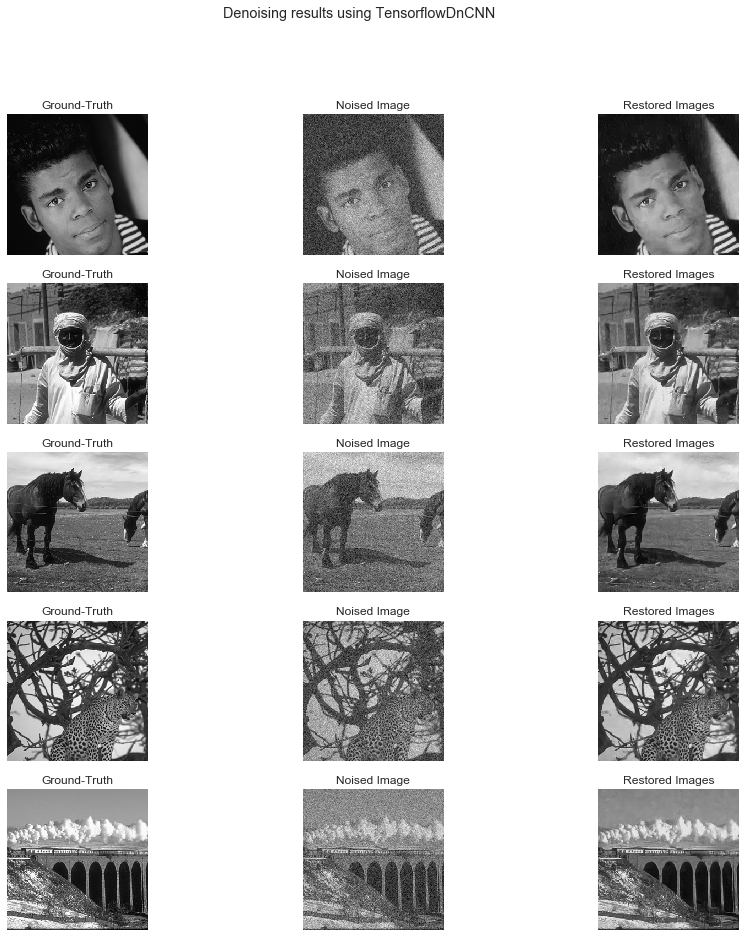

In [15]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = tfmodel_ex2(noisy_imgs)
display_results(clean_imgs, noisy_imgs, rest_imgs, str(tfmodel_ex2))

In [16]:
tfmodel_ex2 = None
tf.reset_default_graph()
gc.collect()

254071

### Using SavedModel API <a class="anchor" id="tf-from-savedmodel"></a>

The charging of a Tensorflow model saved through SavedModel API can be done by passing to model_path the path to the .pb file. We remark that, following the requirements of the API, you need to have a folder in the directory called "variables", that will hold variable values.

In [17]:
tfmodel_ex3 = model.TfModel(model_name="TensorflowDnCNN", logdir="../../training_logs/Tensorflow")
tfmodel_ex3.charge_model(model_path="./Additional Files/Tensorflow Models/from_saved_model/saved_model.pb")

Loading model using SavedModel API.


## Running inference <a class="anchor" id="tf-running-inference"></a>

Inference on TfModels can be done as if the instance was a function (the class implements "__call__") function, as can be saw bellow, where we reuse the TfModel loaded before.

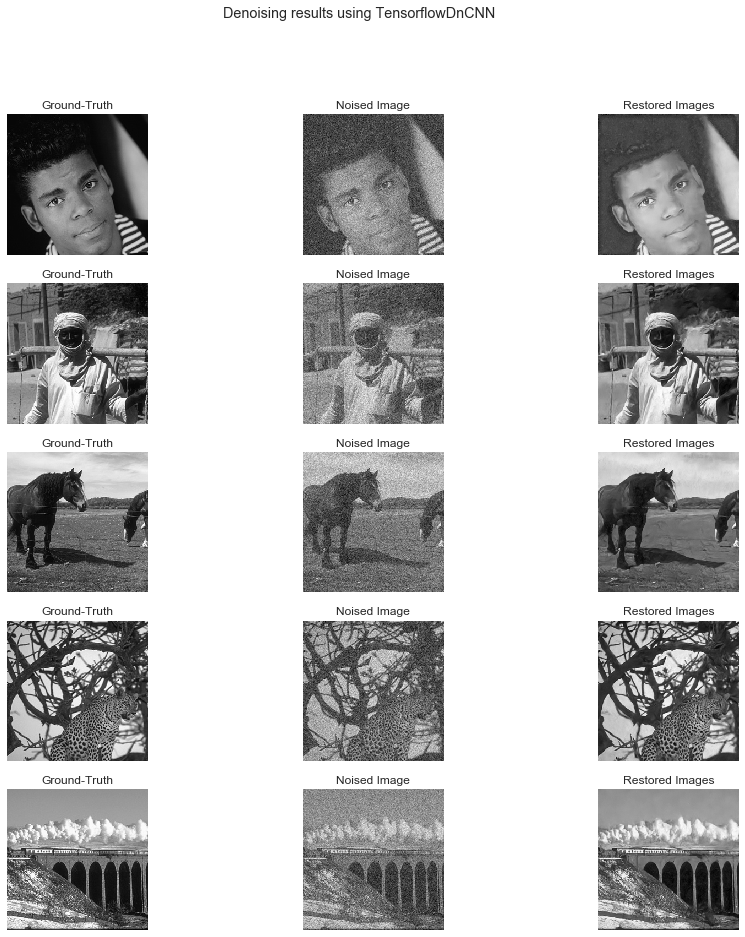

In [18]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = tfmodel_ex3(noisy_imgs)
display_results(clean_imgs, noisy_imgs, rest_imgs, str(tfmodel_ex3))

In [19]:
tfmodel_ex3 = None
tf.reset_default_graph()
gc.collect()

249984

### Training a TfModel <a class="anchor" id="training-a-tfmodel"></a>

To run a training session, you only need to have a training dataset, such as defined in the DatasetUsage.ipynb. Once you created a DatasetGenerator for your training images (and possibly, for you validation images) you can call the "__train__" method from KerasModel class, which takes the following parameters,

* train_generator: any instance of a dataset generator class. This class will yield the data pairs (noisy image, clean image).
* valid_generator: optional. Specify it if you have validation data available.
* n_epochs: number of training epochs. Default is 100.
* n_stages: number of training batches drawn at random from the dataset at each training epoch. Default value is 500.
* learning_rate: constant regulating the weight updates in your model. Default is 1e-3.
* optimizer_name: you can specify the optimizer's name for you model. You can do this by lookin at the names in [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/train). Default is "AdamOptimizer" optimizer.
* metrics: list of metrics that will be tracked during training. There are a couple of useful metrics implemented on __evaluation__ module (such as PSNR, SSIM, MSE) but you can also implement your own following [Keras conventions](https://keras.io/metrics/).
* kcallbacks: list of Keras callbacks. You can either use [Keras default callbacks](https://keras.io/callbacks/) or the callbacks defined on __evaluation__ module.
* loss: a function following the same specification as metrics. It will be using during optimization as an objective function to be minimized.
* valid_steps: number of validation batches drawn at each validation epoch.

To show how a Tensorflow model can be trained, consider the training of a DnCNN as stated on its [original paper](https://arxiv.org/pdf/1608.03981.pdf):

* DnCNN for gaussian denoising has depth 17, n_filters 64, kernel_size (3, 3).
* It is trained on $40 \times 40$ patches extracted from BSDS images, corrupted with fixed-variance gaussian noise ($\sigma=25$, for instance).

For evaluation, we will use a disjoint subset of BSDS, consisting on 68 images which are not present in the training dataset.

In [20]:
# Creating and charging the model
tfmodel_ex4 = model.TfModel(model_name="TensorflowDnCNN", logdir="../../training_logs/Tensorflow")
tfmodel_ex4.charge_model(model_function=tf_dncnn)

Loading model from model function. Be sure to train your network before using it.


In [ ]:
tfmodel_ex4.train(train_generator=train_generator, 
                  valid_generator=valid_generator, 
                  n_epochs=100, 
                  n_stages=465, 
                  learning_rate=1e-3, 
                  optimizer_name="AdamOptimizer", 
                  metrics=[evaluation.psnr, 
                           evaluation.ssim, 
                           evaluation.mse],
                  kcallbacks=[evaluation.DnCNNSchedule(),
                              evaluation.CheckpointCallback(tfmodel_ex4, monitor="val_PSNR"),
                              evaluation.TensorboardImage(valid_generator, tfmodel_ex4)], 
                  loss=evaluation.mse,
                  valid_steps=10)